# Построить графики распределения на гистограммах интервала между обновлениями новостей и количества новостей по интервалам

## 0. Предварительная обработка

In [1]:
# Импортируем все зависимости

%matplotlib inline

import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Смотрим, что у нас в данных
df_cards = pd.read_csv('tempostorm_date.csv', parse_dates=['createdDate'])
df_cards.head()

,Unnamed: 0,date,createdDate,name,playerClass,index
0,0,2014-12-11 20:01:17.997,2014-12-11 20:01:17.997,Windfury Shaman by Reynad,Shaman,0
1,1,2014-12-11 20:13:16.995,2014-12-11 20:13:16.995,BMA's Chowlock Deck,Warlock,1
2,2,2014-12-12 03:56:04.037,2014-12-12 03:56:04.037,[GvG] Mecha Zoo By Gaara,Warlock,2
3,3,2014-12-12 22:57:19.684,2014-12-12 22:57:19.684,Tempo Mage,Mage,3
4,4,2014-12-12 23:50:56.608,2014-12-12 23:50:56.608,Kitkatz's Control Warrior,Warrior,4


In [3]:
# Давайте избавимся, наконец, от лишних и дублирующих колонок
del df_cards['index']
del df_cards['Unnamed: 0']
del df_cards['date']
df_cards.head()

,createdDate,name,playerClass
0,2014-12-11 20:01:17.997,Windfury Shaman by Reynad,Shaman
1,2014-12-11 20:13:16.995,BMA's Chowlock Deck,Warlock
2,2014-12-12 03:56:04.037,[GvG] Mecha Zoo By Gaara,Warlock
3,2014-12-12 22:57:19.684,Tempo Mage,Mage
4,2014-12-12 23:50:56.608,Kitkatz's Control Warrior,Warrior


In [4]:
# И сохраним на будущее
df_cards.to_csv('tempostorm_date_without_index.csv', index=False)

## 1. Интервалы между обновлениями

In [5]:
# Посчитаем интервалы между обновлениями и пропустим первый - для 
# него нет "предыдущего" времени чтобы считать интервал
timediff_series = df_cards['createdDate'].diff()[1:]
timediff_series.head()

1   0 days 00:11:58.998000
2   0 days 07:42:47.042000
3   0 days 19:01:15.647000
4   0 days 00:53:36.924000
5   1 days 07:13:51.982000
Name: createdDate, dtype: timedelta64[ns]

In [6]:
# Переведем в часы, для наочности и чтобы не оперировать с большими числами
timediff_series_in_hours = timediff_series.apply(lambda x: x.total_seconds() / 3600)
timediff_series_in_hours.head()

1     0.199722
2     7.713067
3    19.021013
4     0.893590
5    31.231106
Name: createdDate, dtype: float64

In [7]:
# Конвертируем в список
timediff_list_in_hours = timediff_series_in_hours.values
timediff_list_in_hours[:5]

array([  0.19972167,   7.71306722,  19.02101306,   0.89359   ,  31.23110611])

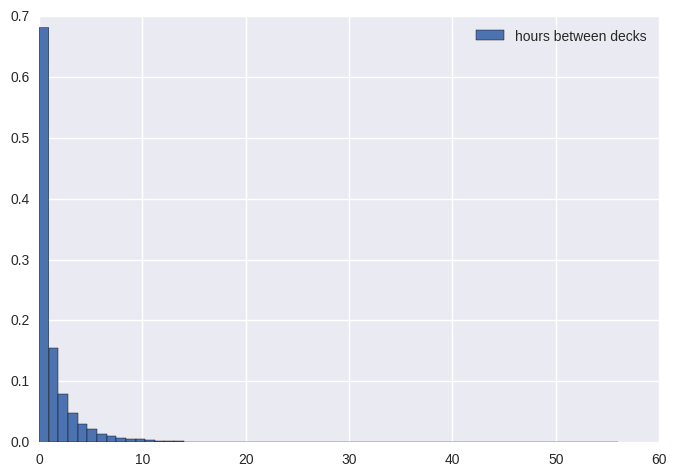

In [8]:
# Проверим визуально похоже ли это на экспоненциальное распределение
plt.hist(timediff_list_in_hours, bins=60, label="hours between decks", normed=True)
plt.legend(loc='best')

In [9]:
# Из статьи на вики мы знаем что параметр лямбда для 
# экспоненциального распределения обратный мат.ожиданию
lambda_from_mean = 1. / np.mean(timediff_list_in_hours)
lambda_from_mean

0.72066744508534342

(0, 10)

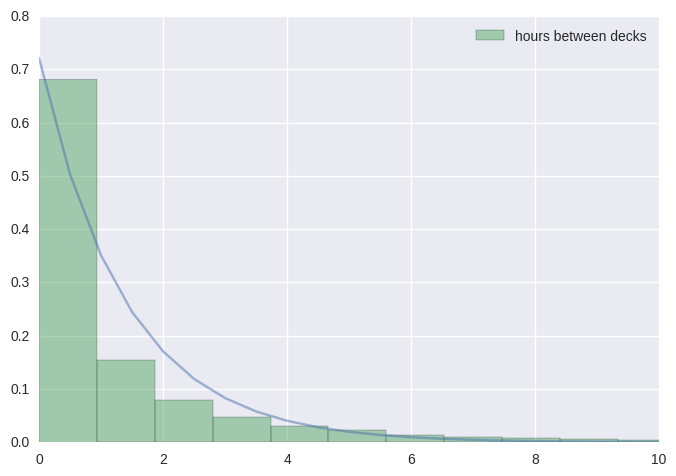

In [10]:
hours = np.arange(0, 60, 0.5)
rv = sp.stats.expon(scale=1./lambda_from_mean)
plt.plot(hours,rv.pdf(hours), alpha=0.5)
plt.hist(timediff_list_in_hours, bins=60, label="hours between decks", normed=True, alpha=0.5)
plt.legend(loc='best')
plt.xlim([0, 10])

## 2. Количество обновлений по интервалам

In [11]:
# Сгруппируем количество обновлений по дням
decks_count_by_creation_day = df_cards.resample('D', on='createdDate')['name'].count()
decks_count_by_creation_day.head()

createdDate
2014-12-11     2
2014-12-12     3
2014-12-13     0
2014-12-14    23
2014-12-15    29
Freq: D, Name: name, dtype: int64

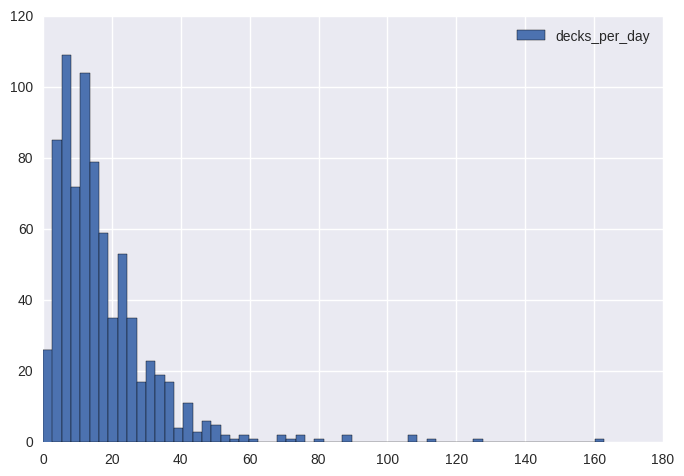

In [12]:
# Посмотрим на гистограмму
plt.hist(decks_count_by_creation_day, bins=60, label="decks_per_day", normed=False)
plt.legend(loc='best')

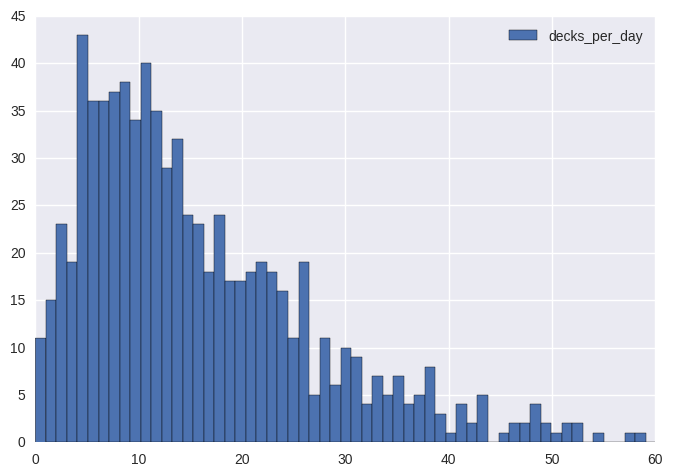

In [13]:
# Обрежем "хвост" и увеличим разрешение
plt.hist(decks_count_by_creation_day, bins=160, label="decks_per_day", normed=False)
plt.xlim([0, 60])
plt.legend(loc='best')

In [14]:
# Посчитаем сколько в среднем мы ожидаем увидеть в день обновлений
# это единственный параметр в распределении Пуассона
average_number_of_decks_per_day = np.mean(decks_count_by_creation_day)
average_number_of_decks_per_day

17.266325224071704

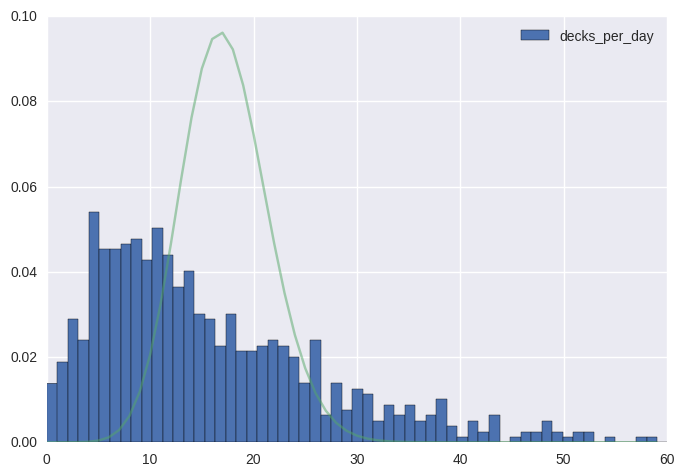

In [15]:
# Построим график
x = np.arange(0, 60, 1)
plt.hist(decks_count_by_creation_day, bins=160, label="decks_per_day", normed=True)
plt.plot(x, sp.stats.poisson(average_number_of_decks_per_day).pmf(x), alpha=0.5)
plt.xlim([0, 60])
plt.legend(loc='best')

Как видим, наше эмпирическое распределение не очень укладывается в Пуассона. Причин тому может быть много - начиная с уже упоминавшейся неравномерности данных и большим количеством outliers (посмотрите какой большой "хвост" мы видим на гистограмме), и заканчивая тем, что распределение Пуассона накладывает очень строгие ограничения, которым мои данные не соответствуют.

Вспомним, что это распределение характеризует количество событий

1. Редких
2. Независимых
3. С фиксированной средней интенсивностью появления
4. С математической точки зрения матожидание в данных должно быть равно среднеквадратическому отклонению.

Мы точно знаем что 3 неверно и можем показать что 4 тоже.